# Pleiades Mass and Velocity

In here, we'll measure Pleiades' mass and velocity and compare to escape velocity

## Load up some data

In [1]:
import sys, os
import numpy as np 

import matplotlib.pyplot as plt 



sys.path.append('..')
import astropy.units as u


print(f'Current Working Directory: {os.getcwd()}')

from locate_cluster_outliers.src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers
from locate_cluster_outliers.src.gaiastars import gaiastars as gs

#construct a dict mapping cluster name in Table1a to its name in Simabad
name_mapper = {'Hyades': 'Hyades',
               'Coma Berenices Cluster':'ComaBer',
               'Pleiades':'Pleiades',
               'Praesepe': 'Praesepe',
               'alpha Per':'alphaPer',
               'IC 2391': 'IC2391',
               'IC 2602': 'IC2602',
               'Blanco 1': 'Blanco1',
               'NGC 2451A': 'NGC2451'}
cluster_info = querySIMBAD(name_mapper, formatGaia=True)

clusters = ['Pleiades', 'Hyades']

print(cluster_info.loc['Pleiades'])

print('\n------------ Gaia Known Members ------------')

cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

cluster_known_members={}
for cl in cluster_names:
    cluster_known_members[cl]=gs(name=f'{cl} Known Members')
    km = list(cluster_members.query('Cluster==@cl').index)
    cluster_known_members[cl].from_source_idlist(km)


Current Working Directory: /home/kevin_leo_mcmanus/locate_cluster_outliers/WorksInProgress
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


typed_id  parallax parallax_error    ra    ra_error   dec    dec_error    pmra     pmdec   radial_velocity rv_error cluster                          coords                       
            mas                   "h:m:s"           "d:m:s"             mas / yr  mas / yr      km / s      km / s                                 deg,deg,pc                     
-------- --------- -------------- -------- -------- -------- --------- --------- --------- --------------- -------- -------- -----------------------------------------------------
Pleiades     7.364              3 03 47 00        4 +24 07.0         4    19.997   -45.548           5.650    0.090 Pleiades 56.75009432548025,24.11647057028541,135.7958527032827

------------ Gaia Known Members ------------
['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.c

In [2]:
#retain just the stars with RV
for cl in cluster_names:
    has_rv = ~np.isnan(cluster_known_members[cl].objs.radial_velocity)
    cluster_known_members[cl].objs = cluster_known_members[cl].objs[has_rv]
    
for cl in cluster_names:
    print(f'{cl} has {len(cluster_known_members[cl].objs)} with RV')

Hyades has 156 with RV
ComaBer has 51 with RV
Pleiades has 239 with RV
Praesepe has 182 with RV
alphaPer has 99 with RV
IC2391 has 48 with RV
IC2602 has 52 with RV
Blanco1 has 57 with RV
NGC2451 has 43 with RV


## Predicted Velocity v. Actual

In [4]:
coords = cluster_known_members['Pleiades'].get_coords()

# 3d offsets from cluster center
offsets_3d = coords.cartesian.xyz-cluster_info.loc['Pleiades']['coords'].cartesian.xyz.reshape(3,1)
distances_3d = np.sqrt((offsets_3d**2).sum(axis=0))

# actual differential velociities
diff_vel_3d = coords.velocity.d_xyz.value - cluster_info.loc['Pleiades']['coords'].velocity.d_xyz.value.reshape(3,1)
act_velocities = np.sqrt((diff_vel_3d**2).sum(axis=0))

# predicted velocities
age = (120e6*u.year).to(u.second) #age of pleiades, 120 Myr in seconds
distances_km = distances_3d.to(u.km)
pred_velocities = (distances_km/age).value

# predicted velocities for age=1 Nyr
age2= (1e6*u.year).to(u.second) #age of pleiades, 1 Myr in seconds
distances_km2 = distances_3d.to(u.km)
pred_velocities2 = (distances_km2/age2).value

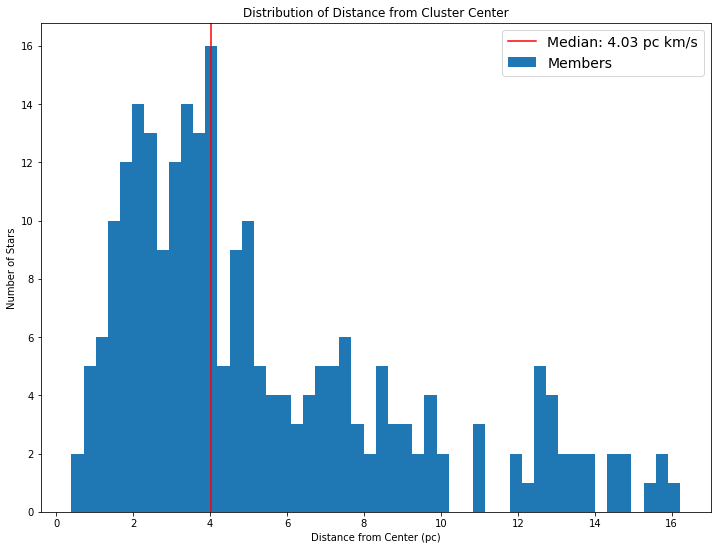

In [5]:
med_pc=np.median(distances_3d)

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

ax.hist(distances_3d.value, bins=50, label='Members')
ax.axvline(med_pc.value, color='red', label=f'Median: {med_pc:.2f} km/s')
ax.set_title('Distribution of Distance from Cluster Center')
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Distance from Center (pc)')
ax.legend(fontsize=14)

(0, 75)

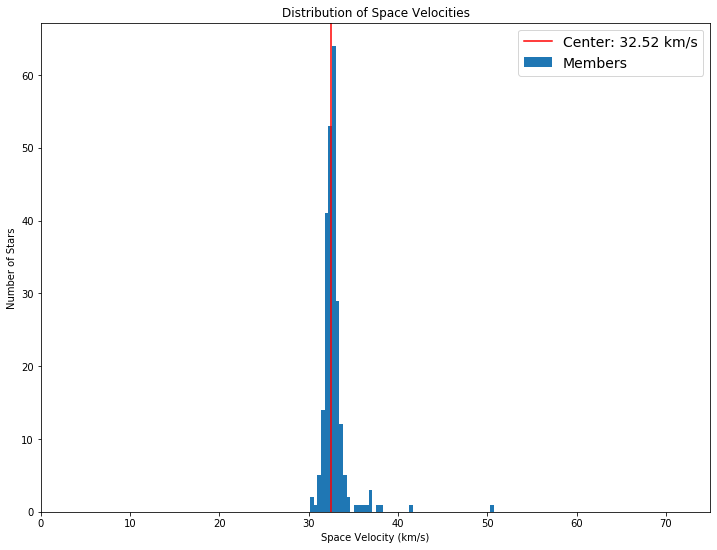

In [6]:
tot_vel = np.sqrt((coords.velocity.d_xyz.value**2).sum(axis=0))
pleiades_vel = np.sqrt((cluster_info.loc['Pleiades']['coords'].velocity.d_xyz.value**2).sum())

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

ax.hist(tot_vel, bins=50, label='Members')
ax.axvline(pleiades_vel, color='red', label=f'Center: {pleiades_vel:.2f} km/s')
ax.set_title('Distribution of Space Velocities')
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Space Velocity (km/s)')
ax.legend(fontsize=14)
ax.set_xlim(0,75)

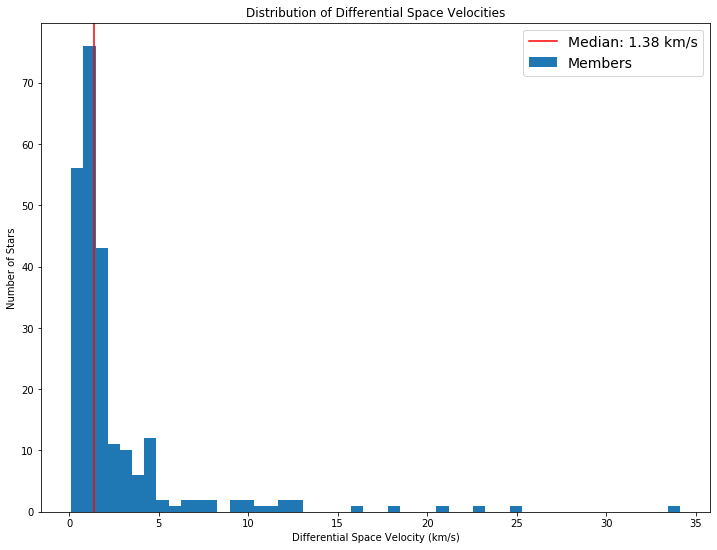

In [7]:
med=np.median(act_velocities)

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

ax.hist(act_velocities, bins=50, label='Members')
ax.axvline(med, color='red', label=f'Median: {med:.2f} km/s')
ax.set_title('Distribution of Differential Space Velocities')
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Differential Space Velocity (km/s)')
ax.legend(fontsize=14)

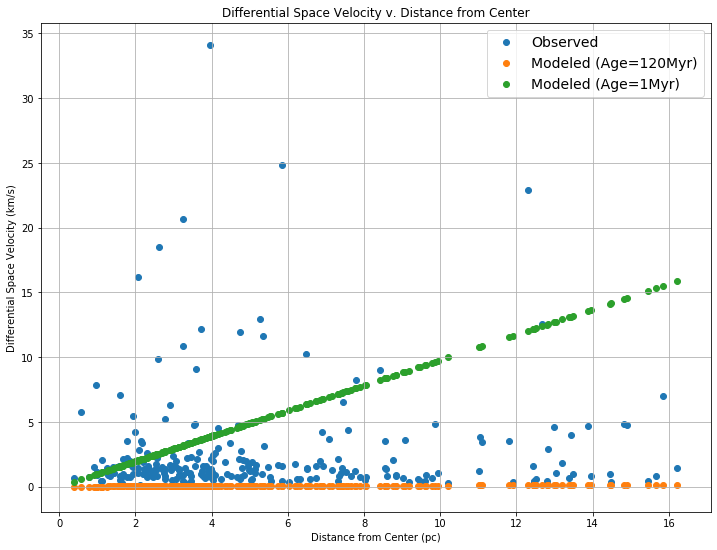

In [8]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

ax.scatter(distances_3d, act_velocities, label='Observed')
ax.scatter(distances_3d, pred_velocities, label='Modeled (Age=120Myr)')
ax.scatter(distances_3d, pred_velocities2, label='Modeled (Age=1Myr)')

ax.set_title('Differential Space Velocity v. Distance from Center')
ax.set_ylabel('Differential Space Velocity (km/s)')
ax.set_xlabel('Distance from Center (pc)')
ax.legend(fontsize=14)
ax.grid()

## Pleiades Mass and Escape Velocity

Solve the enclosed mass formula for mass:
$$
V^2 = GM/r
$$

where $V$ is the observed velocity, $G$ is the gravitional constant, $M$ is the mass within the orbit and $r$ is the radius of orbit. Use median observed velocity and median distance from center.

In [9]:
import astropy.constants  as const
from IPython.display import display, Math

# calculate Pleiades mass encircled at the median velocity and median distance from center
med_v = (np.median(act_velocities)*u.km/u.second).to(u.m/u.second)
med_pc=np.median(distances_3d)

M_Pleiades = (med_pc.to(u.m)*(med_v**2))/const.G

In [10]:
display(Math(rf'Mass\ of\ Pleiades: {M_Pleiades:.3}'))
display(Math(rf'Solar Masses: {M_Pleiades/const.M_sun:.1f}M_\odot'))
n_members = len(cluster_members.query('Cluster==\'Pleiades\''))
display(Math(f'Number\ of\ Members:\ {n_members},\ Average\ Member\ Mass:\ {M_Pleiades/n_members:.3e},\ Average\ Member\ Solar\ Mass:\ {M_Pleiades/n_members/const.M_sun:.2f}M_\odot'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Escape Velocity

Calculate escape velocity from:
$$
V_{escape} = \sqrt{2GM/r}
$$

and plot the result.

In [11]:
#compute escape velocity over range of radii
radii = np.linspace(distances_3d.min(),distances_3d.max(),50)
esc_vel = np.sqrt(2*const.G*M_Pleiades/(radii.to(u.m))).to(u.km/u.second)

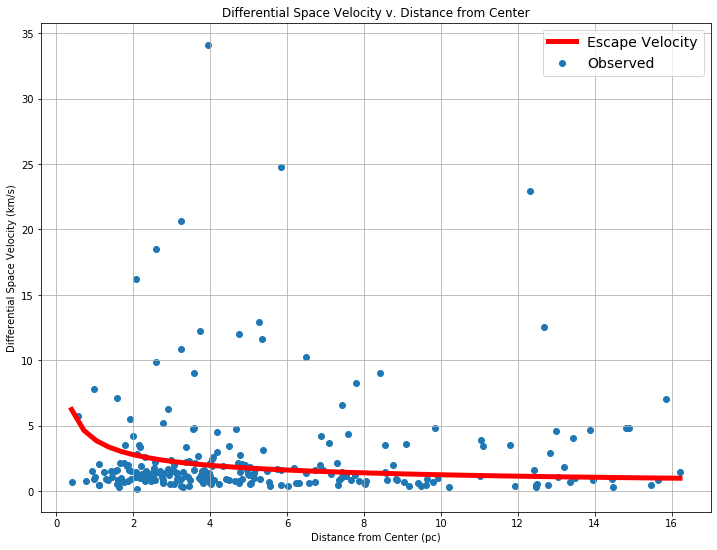

In [12]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

ax.scatter(distances_3d, act_velocities, label='Observed')
ax.plot(radii,esc_vel, color='red', linewidth=5, label='Escape Velocity')

ax.set_title('Differential Space Velocity v. Distance from Center')
ax.set_ylabel('Differential Space Velocity (km/s)')
ax.set_xlabel('Distance from Center (pc)')
ax.legend(fontsize=14)
ax.grid()